## Final Project Submission

Please fill out:
* Student name: Steven Champion
* Student pace: part time
* Scheduled project review date/time: 08/22/2019 15:00 MST
* Instructor name: Abhineet Kulkarni
* Blog post URL:


Goal: Clean, explore, and model this dataset with a multivariate linear regression to predict the sale price of houses as accurately as possible.

In [182]:
#library imports and other setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

plt.style.use('ggplot')
sns.set_style('whitegrid')

In [183]:
df_kc_house = pd.read_csv('kc_house_data.csv')

In [184]:
print(df_kc_house.columns)
print('\n')
first_shape = df_kc_house.shape
print('Shape: ', first_shape)
print('\n')
print(df_kc_house.info())
print('\n')
df_kc_house.head()

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


Shape:  (21597, 21)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [185]:
date = pd.to_datetime(df_kc_house.date)
df_kc_house.date = date
df_kc_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11), object(1)
memory 

In [186]:
df_kc_house = df_kc_house.set_index('price')

My first step of data cleaning will be to check for duplicates (I started with id as a unique identifier):

In [187]:
print(df_kc_house.duplicated('id').value_counts())
df_grouped = df_kc_house.groupby(['id','price']).sum()
df_grouped.head(1)

False    21420
True       177
dtype: int64


,,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,price,,,,,,,,,,,,,,,,,
1000102,280000.0,6,3.0,2400,9373,2.0,0.0,0.0,3,7,2400,1991,0.0,98002,47.3262,-122.214,2060,7316


After investigating the duplicates of 'id' it appears some houses were evaluated multiple times and have different price values as well as dates. This data is still valuable in asking the question of factors influencing price, so I have chosen to keep all duplicated ids that don't share a date (which as it turns out is all of them, see below).

In [188]:
df_kc_house.duplicated(['id','date']).value_counts()

False    21597
dtype: int64

In [189]:
for column in df_kc_house:
    if df_kc_house[column].count() != first_shape[0]:
        print(column, df_kc_house[column].count(),'/',first_shape[0])
        print(column,100*df_kc_house[column].count()/first_shape[0],'% non-null')

waterfront 19221 / 21597
waterfront 88.9984720100014 % non-null
view 21534 / 21597
view 99.708292818447 % non-null
yr_renovated 17755 / 21597
yr_renovated 82.21049219799046 % non-null


So waterfront, view, and yr_renovated all need to be cleaned:

waterfront:

In [190]:
df_kc_house.waterfront.value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

Due to the already categorical nature of this column, the easiest solution is to just create another category for unknown values. 

In [191]:
df_kc_house.waterfront = df_kc_house.waterfront.fillna('?')
df_kc_house.waterfront.value_counts()

0.0    19075
?       2376
1.0      146
Name: waterfront, dtype: int64

view:

In [192]:
df_kc_house = df_kc_house.dropna(subset=['view'], axis='rows')
df_kc_house.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 21534 entries, 221900.0 to 325000.0
Data columns (total 20 columns):
id               21534 non-null int64
date             21534 non-null datetime64[ns]
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       21534 non-null object
view             21534 non-null float64
condition        21534 non-null int64
grade            21534 non-null int64
sqft_above       21534 non-null int64
sqft_basement    21534 non-null object
yr_built         21534 non-null int64
yr_renovated     17704 non-null float64
zipcode          21534 non-null int64
lat              21534 non-null float64
long             21534 non-null float64
sqft_living15    21534 non-null int64
sqft_lot15       21534 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(11), object(2)
memory usage: 3.5+ MB


I have elected to drop the view null values, as the data set is relatively large and the missing view values only make up .3% of the total data. 

yr_renovated:

Number of renovations  743


Text(0, 0.5, 'Count')

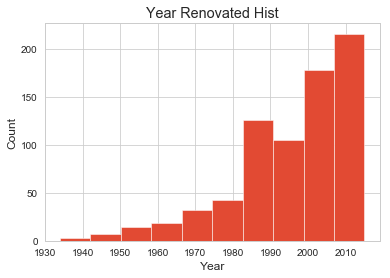

In [193]:
renovated = df_kc_house.loc[(df_kc_house.yr_renovated != 0)&df_kc_house.yr_renovated.notnull()]
print('Number of renovations ', renovated.shape[0])
# renovated.yr_renovated.value_counts()
renovated.yr_renovated.hist(bins = 10)
plt.title('Year Renovated Hist')
plt.xlabel('Year')
plt.ylabel('Count')

My plan is to drop this entire column now and deal with it separately later.

In [194]:
df_kc_mult = df_kc_house.drop(columns=['yr_renovated'])
df_kc_mult.head(1)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
price,,,,,,,,,,,,,,,,,,,
221900.0,7129300520,2014-10-13,3,1.0,1180,5650,1.0,?,0.0,3,7,1180,0.0,1955,98178,47.5112,-122.257,1340,5650


In [195]:
df_kc_mult.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 21534 entries, 221900.0 to 325000.0
Data columns (total 19 columns):
id               21534 non-null int64
date             21534 non-null datetime64[ns]
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       21534 non-null object
view             21534 non-null float64
condition        21534 non-null int64
grade            21534 non-null int64
sqft_above       21534 non-null int64
sqft_basement    21534 non-null object
yr_built         21534 non-null int64
zipcode          21534 non-null int64
lat              21534 non-null float64
long             21534 non-null float64
sqft_living15    21534 non-null int64
sqft_lot15       21534 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(11), object(2)
memory usage: 3.3+ MB


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Now the data is cleaned, I can begin on regression analysis. The plan is to model multiple linear regression on the remaining columns, then model a single regression on the rennovated column dropped earlier. 

In [196]:
df_kc_mult = df_kc_mult.drop(columns=['id'])
df_kc_mult.head(1)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
price,,,,,,,,,,,,,,,,,,
221900.0,2014-10-13,3,1.0,1180,5650,1.0,?,0.0,3,7,1180,0.0,1955,98178,47.5112,-122.257,1340,5650


In [197]:
abs(df_kc_mult.corr())>0.75 #i just used the recommended value of 0.75 from the lab

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
bedrooms,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,True,True,False,False,False,False,True,True,False,False,False,False,True,False
sqft_lot,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
grade,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False
sqft_above,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False
yr_built,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


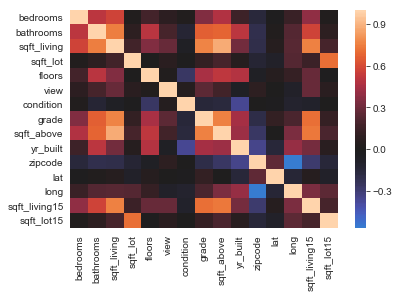

In [198]:
sns.heatmap(df_kc_mult.corr(), center=0)

In [199]:
cols_to_drop = ['sqft_above','grade','sqft_living15','bathrooms']
df_kc_mult = df_kc_mult.drop(columns = cols_to_drop)
df_kc_mult.head(1)

,date,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,zipcode,lat,long,sqft_lot15
price,,,,,,,,,,,,,,
221900.0,2014-10-13,3,1180,5650,1.0,?,0.0,3,0.0,1955,98178,47.5112,-122.257,5650


bathrooms, grade, sqft_above, and sqft_living15 all seem correlated with sqft_living, so to keep the model cleaner and make it easier to find underlying causes I have removed the aforementioned columns.

In [222]:
non_normal = ['sqft_lot','sqft_lot15']
for feat in non_normal:
    df_kc_mult[feat] = df_kc_mult[feat].map(lambda x: np.log(x))

In [220]:
# pd.plotting.scatter_matrix(df_kc_mult,figsize=(15,15))

ValueError: supplied range of [-inf, 1.3862943611198906] is not finite

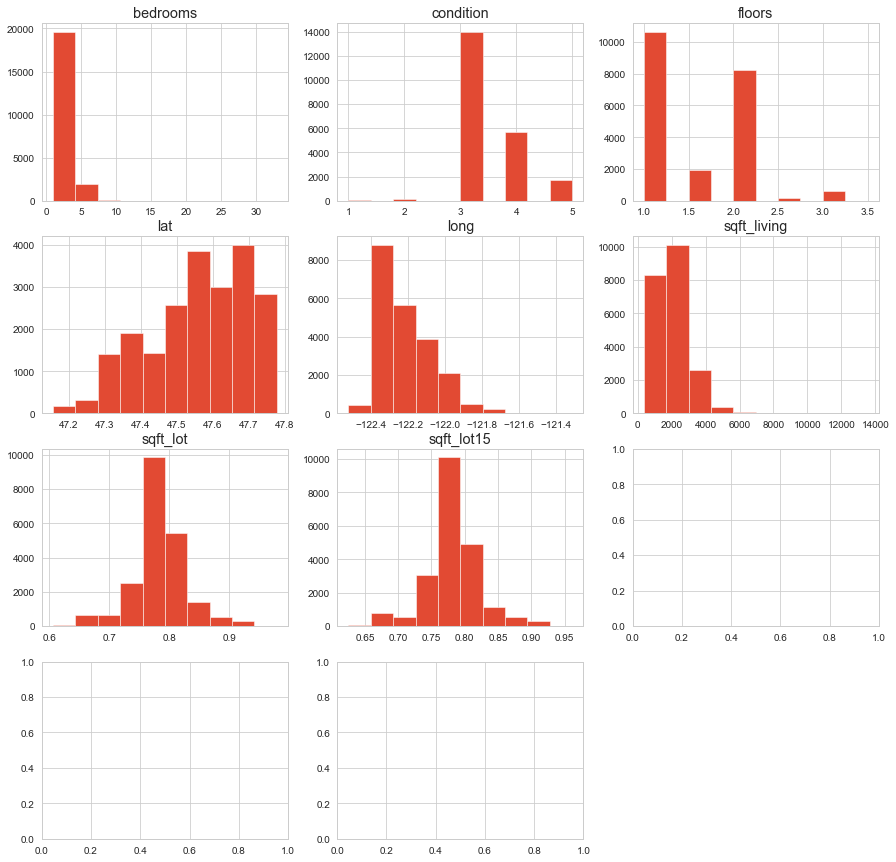

In [221]:
df_kc_mult.hist(figsize = (15,15))

In [201]:
# df_kc_house['continuous_date'] = (df_kc_house['date'].dt.year)+(df_kc_house['date'].dt.dayofyear/366)
# df_kc_house.head(1)

In [202]:
# plt.plot(df_kc_house['continuous_date'],df_kc_house['price'],'.', c= 'teal')

In [203]:
# df_kc_house.hist(figsize=(15,15))